# FIRE - Far-ultraviolet Irradiated Rotational Evolution model

## The Spin Evolution Model

**Last update (Julia Roquette - 3rd August 2021):** Added to github.

**Previous updates**: 

**juliaroquette@12thJuly2021:** This notebook contains the optimised version of the spin evolution code developed as part of the study presented in Roquette et al (2021)

More details about the initial implementation of the model can be found in the notebook `[PaperI]SpinEvolutionModel.ipynb`. The optimisations implemented reduced the execution time of the model to roughly half.

In [2]:
import numpy as np
import matplotlib.pylab as plt
import astropy.units as u
import matplotlib as mpl

**Note on astropy.units** Following https://docs.astropy.org/en/stable/units/equivalencies.html

I will start by creating a base for a `class` with all functions required for the model:

The angular momentum of a star is $J_*=I_*\Omega_*$, and its temporal evolution will be given by:

$\frac{dJ_*}{dt}=\tau$

where $\tau$ are the torques acting on the star.
Using the product rule, this can be re-written as:

$\tau=\frac{d(I_*\Omega_*)}{dt}=I_*\frac{d\Omega_*}{dt}+\Omega_*\frac{dI_*}{dt}$

From this equation, the rotational evolution of the star can be written as:

$\frac{d\Omega_*}{dt}=\frac{\tau}{I_*}-\frac{\Omega*}{I}\frac{dI_*}{dt}\;\;\;\;\;\;\;\;\mathrm{(1)}$

I will be using [Matt et al (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...799L..23M/abstract) wind torque, therefore, the `class` starts with the definition of constant values adopted in Matt et al. 2015 formulation:

- $\chi=10$ Inverse critical Rossby number for magnetic saturation in solar units

- $p=2$ rotation activity scaling 

- $M_\odot=1.99\times10^{33}$ g

- $R_\odot=6.96\times10^{10}$ cm

- $\Omega_\odot=2.6\times10^{-6}$ Hz

- $I_\odot=0.7\times10^{54}g\;\mathrm{cm}^2$

- $t_\odot=4.55\times10^{9}$ yr

- $\tau_{cz\odot}=13.7798$ d<sup id="N1">[[1]](#f1)</sup> normalization for the convective turnover time

<b id="N1">[1]</b> As discussed below, since I updated the Matt+2015 model from the Baraffe et al. (1998) to the Baraffe et al. (2015) models, I had to update the 1M$\odot$ value of $\tau_\mathrm{cz}$ as well. 

```python
class SpinEvolutionCode:
    """
    My spin evolution code

    """
````

This initialisation part defines all the constants required by the wind-torque, sets the model's initial time, and loads the Baraffe+15 grid. Note that the mass is not set up during initialisation in this version but only during the spin-evolution part. This means that when simulating a large sample of stars, this initialisation only needs to be run once. 

```python
    def __init__(self, t0):
    def __init__(self, t0):
        """
        M should be in solar masses
        to should be in years - the initial time step of the model
        Omegao should be in days
        """        
        #define constants
        self.CHI = 10.
        self.P = 2.
        self.M_o = 1.99e33 << u.g
        self.OMEGA_o = u.def_unit(r'\Omega_\odot',  2.6*1e-6*u.Hz)
        self.R_o = 6.96e10 << u.cm
        self.I_o = 7e53 << u.g*(u.cm**2)    
        self.TIME_o = 4.55e9 << u.yr
        self.TAU_CZ_o = 13.7798 << u.d # Value updated in the context of B15
                        # 12.9 << u.d
        self.baraffe = BHAC15_MassTrack() #loads the Baraffe+15 grid.
        if not isinstance(t0, type(1*u.yr)):
            self.t0 = t0 << u.yr     
        else: 
            self.t0 = t0
        # Makes sure that the initial time isn't before the initial time in 
        #the BHAC15 grid
        if self.t0.value < 10**np.nanmin(self.baraffe.BHAC15['log_t_yr']):
            self.t0 = 10**np.nanmin(self.baraffe.BHAC15['log_t_yr']) << u.yr
            print('Minimum value must be inside the age range of the Baraffe \
                   Model, I reset it to {0}'.format(t0.value/1e6))   
````

This function interpolates Radius, the momentum of inertia and effective temperature from the Baraffe+15 grid. Note that a `self.baraffe` object must be already defined AND loaded for a given mass for the function to be called. In the previous step, I called `self.baraffe = BHAC15_MassTrack()`, which loads the grid, but *DO NOT* define the objects `self.R`, `self.I` and `self.T`. In this code, these will only be defined inside the function `dOmegadt`, when I call`self.baraffe.getMassTrack(self.M)`.
```python
    def interpolateBaraffe(self,t):
        """
        given a time t in yrs, interpolate parameters
        of interest from Baraffe+2015 models
        and update local variables for R, I and T
        --
        input:
        t: time in yrs
        """
        #bouds_error=False will returns np.nan if out of bounds
        self.R, self.I, self.T = interp1d(self.baraffe.Age, 
                                          (self.baraffe.R, self.baraffe.I, 
                                           self.baraffe.Teff), 
                                             kind='linear', bounds_error=False 
                                            )(t)
```

Next, by knowing how `I` varies with `t`, so the first step towards solving equation (1) is to use this to derive the term $\frac{dI}{dt}$. This is done by the following function, which uses the [`scipy.interpolate.UnivariateSpline`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html) to evaluate this derivative.

```python
    def update_dIdt(self, t):    
        """
        calculates the derivative dI/dt at a position t
        """
        y = self.baraffe.I*self.M_o*self.R_o**2
        x = (self.baraffe.Age*u.yr).to(u.s)
        spl = UnivariateSpline(x, y, k=3)
        self.dIdt = spl.derivative(n = 1)(t.to(u.s).value)*(u.cm**2)*u.g/u.s        
```

**NOTE:'** For more details on the Baraffe+15 grid, including useful plots, see `BHAC15.pynb` 

#### Assumption 1: 

For the duration of the star-disk interaction, which is described by $\tau_D$, the rotation of the star is constant.

$\frac{d\Omega_*}{dt}=0$ and this implies that $\frac{\tau}{I_*}=\frac{\Omega*}{I}\frac{dI_*}{dt}$, which is the same as saying that the torques in action will compensate the Pre Main Sequence Contraction.

**NOTE:** for derivations of $\tau_D$ see `FUV_TauD.ipynb`

#### Assumption 2: 

After $\tau_D$, the only torque in action is the stellar wind ($\tau=\tau_W$). For these torques, I will adopt Matt et al. 2015 torques as follow. 

$\tau_W=-T_o\Big(\frac{\tau_{cz}}{\tau_{cz\odot}}\Big)^p\Big(\frac{\Omega_*}{\Omega_{\odot}}\Big)^{p+1}$ in the unsaturated regime

$\tau_W=-T_o\chi^p\Big(\frac{\Omega_*}{\Omega_{\odot}}\Big)$  in the saturated regime 

where:
    
$T_o=T_o(T_\odot,M_*,R_*)=\frac{2}{3}9.5\times10^{30}\mathrm{erg}\Big(\frac{R_*}{R_\odot}\Big)^{3.1}\Big(\frac{M_*}{M_\odot}\Big)^{0.5}$, and 


$\chi\equiv\frac{R_{o\odot}}{R_{oSAT}}\equiv\frac{\Omega_{oSAT}\tau_{cz}}{\Omega_{o\odot}\tau_{cz\odot}}$, where $R_o\equiv\frac{1}{\Omega_*\tau_{cz}}$ is the Rossby number

Now, using these definitions we have:

$\tau_W=-T_o\Big(\frac{\tau_{cz}}{\tau_{cz\odot}}\Big)^2\Big(\frac{\Omega_*}{\Omega_{\odot}}\Big)^{3}$ in the unsaturated regime

$\tau_W=-100T_o\Big(\frac{\Omega_*}{\Omega_{\odot}}\Big)$  in the saturated regime 

And we can code that in terms of $\Omega_*$ and $\tau_{cz}$.

Now, $\chi=10$ gives us means to define what is the saturated regime:

$\chi=1=\frac{\Omega_{oSAT}\tau_{cz}}{\Omega_{o\odot}\tau_{cz\odot}}$, and so $\Omega_\mathrm{SAT}=10\frac{\Omega_\odot\tau_{cz\odot}}{\tau_{cz}}$

**Note that** I want my model to be in terms of $\Omega_\odot$ so $\Omega\rightarrow\frac{\Omega}{\Omega_\odot}$

$\tau_W=-T_o\Big(\frac{\tau_{cz}}{\tau_{cz\odot}}\Big)^2\Big(\Omega\Big)^{3}$ in the unsaturated regime

$\tau_W=-100T_o\Big(\Omega\Big)$  in the saturated regime 

The first step here is, then, to derive $T_0$ at any timestep:

```python         
    def update_To(self):
        """
        updates the Matt+15 torque scalling term `self.To`
        """
        self.To = 6.3e30*((self.R)**3.1)*((self.M)**0.5) << u.erg
```                

Next, the convective turnover time, $\tau_{cz}$ which can be estimated from [Cranmer&Saar 2011](https://ui.adsabs.harvard.edu/abs/2011ApJ...741...54C/abstract) equation (36):

$\tau_{cz}=314.24\exp\Bigg[-\Big(\frac{T_{eff}}{1952.5 K}\Big)-\Big(\frac{T_{eff}}{6250K}\Big)^{18}\Bigg] + 0.002$

```python
def tau_cz_CS11(self):
        """
        Derives the convective turnover timescale as in Cranmer & Saar 2011
        """
        self.tau_cz = (314.24*np.exp( -(self.T/1952.5) - (self.T/6250.)**18) + 
                       0.002) << u.d
```        

It is also important to keep track of the saturation limit, which is done by this function:
```python
    def saturation_limit(self):
        """
        Gives the saturation limit based on the current
        local variables.
        """
        return (self.CHI*self.TAU_CZ_o/self.tau_cz).value << self.OMEGA_o   
```

And finally, the wind-torque will be defined at the function:

```python
    def tau_w(self, Omega):
        """
        Derives the wind torque based on the current values of the objects for
        M, R and T, while the rotation Omega is given as input
        """ 
        if Omega < self.saturation_limit():
            return - self.To*((self.tau_cz/self.TAU_CZ_o)**self.P)*\
                ((Omega.value)**(self.P + 1))
        else:
            return - self.To*(self.CHI**self.P)*(Omega.value)   
 ```

With all that defined, the `time_update` function will update all the object variables created at a given time `t`:

```python
    def time_update(self,t):
        """
        updates parameters at any time t
        """
        self.interpolateBaraffe(t.value) # this will set the values of R, I and T
        self.tau_cz_CS11() # set tau_cz
        self.update_To() # set To
        self.update_dIdt(t) #get dIdt
````

##### Euler Method

Finally, I need a numerical method for solving equation (1), and for that, I am using the Euler Method with time-variable steps. This gives me a first-order numerical procedure for solving ordinary differential equations given an initial value.

(Some References: 

https://en.wikipedia.org/wiki/Euler_method

Book: A Primer on Scientific Programming with Python - Hans Petter Langtangen https://hplgit.github.io/) 


Here's follows some background steps prior to the final implementation in the code.

Given:

$y'(t)=f(t,y(t)),\;\;$ and $\;\;y(t_o)=y_o$

Aproximate solution at a time $t_{i+1}$: 
$y_{i+1}=y_i+\Delta tf(y_k,t_k)$, with $\Delta t=t_{i+1}-t_i$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def Euler(f, y0, T, n):
    """
    Solve y’=f(y,t), y(0)=y0, with n steps until t=T.
    See, for example: https://hplgit.github.io/primer.html/doc/pub/half/book.pdf
    """ 
    n=int(n)
    t = np.zeros(n+1)
    y = np.zeros(n+1)
    y[0] = y0
    t[0] = 0
    dt = T/float(n)
    for k in range(n):
        t[k+1] = t[k] + dt
        y[k+1] = y[k] + dt*f(y[k], t[k])
    return y, t

##### Example :

$\frac{dy}{dt}=y\;\;\;\;\;\;\;$ $y\rightarrow$`f`

with $y(0)=1\;\;\;\;\;\;\;$ $1\rightarrow$`Y0`

$\int\limits^y_{1}\frac{dy}{y}=\int\limits^t_{0}dt$

$\ln{y}=t$

$y(t)=e^t\;\;\;\;$  (exact solution)

Will solve it from 0 to 3, thus T -> 3

In [4]:
def f(y,t):
    return(y)
y0=1
T=3

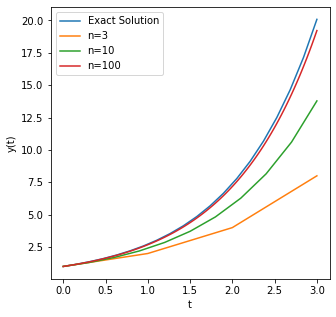

In [5]:
t1=np.linspace(0,3,num=20,dtype=float)
fig, ax = plt.subplots(figsize = (5,5))
plt.plot(t1,np.exp(t1),label='Exact Solution')
plt.plot(Euler(f, y0, T, 3)[1],Euler(f, y0, T, 3)[0],label='n=3')
plt.plot(Euler(f, y0, T, 10)[1],Euler(f, y0, T, 10)[0],label='n=10')
plt.plot(Euler(f, y0, T, 100)[1],Euler(f, y0, T, 100)[0],label='n=100')
plt.ylabel('y(t)')
plt.xlabel('t')
plt.legend()

In the case of the rotational evolution equation:

$y'(t)=f(t,y(t))\rightarrow\frac{d\Omega}{dt}$

$\frac{d\Omega}{dt}=\frac{\tau_W}{I}-\frac{\Omega}{I}\times\frac{dI}{dt}$

Now, there are a couple of things in this equation that will also change with time. $\tau_W=\tau_W(\Omega(t),M,R)$ and $\frac{dI}{dt}$ will both be time-dependent, but in a way that is already tabulated. 

Additionally, I don't want the timesteps to be fixed. First, I don't really need to estimate omega in the whole 1Myr to 5Gyr time range in which I am interested. Second, because I want to guarantee I can take snapshots of the model at pre-defined ages (for example, at the ages of observed clusters).

To deal with that, I need to introduce a variable timestep, `dt`, to the Euler method. 

The first step is to code a function that applies the Euler method for a single time step, with `dt` inputted to this function and defined outside the function. In this approach, my `Euler_` function dos only one step of the Euler method give a timestep `dt` that is defined by an external function as described below. 

```python
    def Euler_(self, f, Omega, t0, dt, wind=True, structure=True, 
               breakup=True):
        """
        Estimates one step of the Euler method
        
        ----
        if breakup = True: saturates Omega at the critical value
        """  
        O = Omega + dt*self.f(Omega, wind = wind, structure = structure)
        if bool(breakup):
            Ocrit = self.BreakUp()
            if (O > Ocrit):
                O = Ocrit 
        return O, t0 + dt    
```


See note <sup id="N1">[[2]](#f1)</sup> for note on `breakup=True` keyword

Note also that I wanted to have the flexibility of turning off some of the terms of the equation, so I coded a $f(y,t)=f_W(y,t)+f_{dIdt}(y,t)$, instead of the simply $f(y,t)$ I currently have.

For $f_W(y,t)=\frac{\tau_W}{I_*}$, I have: 

```python
    def f_W(self, Omega):
        """
        Wind torque term of the rotation evolution equation
        Omega is the rotation rate in solar units
        """
        return (self.tau_w(Omega)/(self.I*self.M_o*self.R_o**2))        
```

For the momentum of inertia term, since I want my model to be in terms of $\Omega_\odot$


$-\frac{\Omega}{I}\times\frac{dI}{dt}\rightarrow-\frac{\Omega\Omega\odot}{I}\times\frac{dI}{dt}$

Note that both $I$ and $dI$ are in terms of $I_\odot$, so this term will cancel out - including their units.

So $f_{dIdt}(y,t)=\frac{\Omega}{I}\times\frac{dI}{dt}$:

```python
    def f_dIdt(self, Omega):
        """
        Term including of the rotational evolution including the  
        variation in the Momentum of Ineria
        
        """       
        return - Omega*self.dIdt/(self.I*self.M_o*self.R_o**2)
```

With this approach, $f(y,t)$ is:  

```python
    def f(self, Omega, wind=True, structure=True):
        """
        Set up a function that will be feed to the Euler method
        """
        return bool(wind).real*self.f_W(Omega) + \
               bool(structure).real*self.f_dIdt(Omega)   
```

When using a variable timestep, we need to know how much is the $d\Omega$ that will increase $\Omega$ by a certain factor $e$, so

$e=\frac{d\Omega}{\Omega}\rightarrow d\Omega=e\Omega$

For that, we have to look at each term of the differential equation separately. Otherwise, we will introduce a bug in the code in the part of the rotational evolution curve in which $\frac{d\Omega}{dt}=0$.

for the first term:

$\frac{d\Omega}{dt}=\frac{\tau}{I}\rightarrow d\Omega=\frac{\tau}{I}dt$

So: $e\Omega=\frac{\tau}{I}dt\rightarrow dt=e\Omega\frac{I}{\tau}$

For the structure term:

$\frac{d\Omega}{dt}=-\frac{\Omega}{I}\frac{dI}{dt}\rightarrow d\Omega=-\frac{\Omega}{I}\frac{dI}{dt}dt=e\Omega$

$dt=-\frac{eI}{\frac{dI}{dt}}$

Finally, we also need a function that deals with the different terms of the equation and decides which of the terms contributes more and estimate $dt$ accordingly.


```python
    def get_dt(self, Omega, e, structure=True, wind=True):
        """
        estimates the best timestep by comparing how much the wind and the
        structure will contribute to changing omega, given an efficiency term 
        e
        """ 
        if bool(wind) and bool(structure):
            dt_s = - e*self.I*self.M_o*(self.R_o**2)/self.dIdt
            dt_w = e*self.I*self.M_o*(self.R_o**2)*(Omega)/self.tau_w(Omega)
            return min(abs(dt_s), abs(dt_w)).to(u.yr)
        elif not bool(wind) and bool(structure):
            return abs(e*self.I*self.M_o*(self.R_o**2)/self.dIdt)
        elif bool(wind) and not bool(structure):
            return abs(e*self.I*self.M_o*(self.R_o**2)*\
                       (Omega)/self.tau_w(Omega))   
```

#### The break-up limit

Finally, I need to make sure that the model won't result in stars rotating faster than the break-up limit. For now, I will simply saturate the rotational evolution at this limit with the argument that if the stars approach the break-up limit, their winds would be augmented, and an increased mass-loss would prevent them from crossing this limit. 

From Maeder's Book ["Physics, formation and evolution of rotating stars"](https://link.springer.com/book/10.1007/978-3-540-76949-1) equation 2.13

$\Omega_{crit}= \sqrt{\frac{GM}{R_e^3}}$, where $R_e$ is the equatorial radius at break-up. 
The radius in the Baraffe model is the polar radius - which doesn't change with rotation. For stars rotating close to the breakup speed, $R_e=1.5R_p$.

```python
    def BreakUp(self):
        """
        estimates the breakup rotation 
        for a star of given mass and age.
        Omega=sqrt(GM/Re**3)
        Re=1.5Rp 
        Ro used in Baraffe models: Rs=6.96d10cm
        Mo=1.99e33g 
        ---
        Returns the Breakup limit in OmegaSun units
        """  
        return np.sqrt((self.M*self.M_o*G.cgs)/(1.5*self.R*self.R_o)**3)\
            << self.OMEGA_o
````

<b id="N1">[2]</b> This saturation is implemented in the function
```python
Euler_(f, Omega, t0, dt, wind=True, structure=True, breakup=True)
````
when the keyword `breakup=True` is set.

Note that the Baraffe model is not calibrated to the Sun, and therefore a 1M$\odot$ at 4.6Gyr will have a slightly larger radius than the Sun.

### Rotational Evolution

The code below solves the differential equation and also deals with **Assumption 1** by keeping the star with constant rotation if the `tau_d` flag is different from zero.  The code also deals with the snapshot mode. In this mode, even though the model is evolved with each step increasing the rotation by a factor $e$, only the rotation at the snapshot ages is registered.

```python
   def dOmegadt(self, M, Omega0, t, tau_d=0, e=0.1, wind=True, 
                 structure=True, snapshot=False, breakup=True):
        """
        __
        input
        _
        M: stellar mass in solar masses
        Omega0: initial rotation
        t: vector with the key timesteps
        e: [0,1] tolerance of minimal variation of Omega do define a 
           intermediary timestep
        wind: [True] for activate wind term
        structure: [True] for activate structure term    
        snapshot: [True] the model will return only data for the timesteps 
                  listed in t
        breakup:  [True] saturates the rotation at the break-up speed
        __
        output
        Omega and t with no units
        _
        
        """
        #define a local variable for the Mass
        self.M = M
        if M == 0.1: 
            self.M += 0.000001  
        # locally load the grid for M
        self.baraffe.getMassTrack(self.M)  
        # define all initial parameters relevant to the spin evolution
        self.time_update(self.t0) 
        #
        try:
            len(t)
        except TypeError:
            t = np.array([t])
        else:
            t = np.array(t)
        if not isinstance(Omega0, type(self.OMEGA_o)):
            Omega0 = Omega0 << self.OMEGA_o
        if Omega0 >= self.BreakUp():
            print('Initial rotation faster than Break-Up!')   
        if not isinstance(t, type(u.yr)):
            t = t << u.yr    
        if bool(snapshot): 
            t_out = np.full(len(t) + 1, np.nan)
            t_out[0] = self.t0.value
            t_out[1:] = 1.*t        
        if bool(snapshot): t_mas = []        
        for i, T in enumerate(t):
            if T.value > np.nanmax(self.baraffe.Age): #makes sure I am not 
                                                #going beyond Baraffe's models    
                if bool(snapshot): t_mas.append(i + 1) # save the index
                t[i] = (np.nanmax(self.baraffe.Age) - 1e6) << u.yr
                print('Maximum value must be inside the age range of the \
                      Baraffe Model')
        if not isinstance(tau_d, type(1*u.yr)):
            tau_d= tau_d << u.yr 
        if (tau_d != 0) & (tau_d.value < 1e5):
            print(r'Is $\tau_D$ in the right units?')
        t_ = []
        Omega_ = []
        t_.append(self.t0.value)
        Omega_.append(Omega0.value)
        tk_o = 1.*self.t0
        # test if spin-evolution needs to be calculated at all:
        if t.max() > tau_d:
            n = 0
            # test if tau_D is before t0:
            if tau_d > self.t0:
    
                while t[n] < tau_d: 
                    t_.append(t[n].value)
                    Omega_.append(Omega0.value)
                    tk_o = t[n]
                    n += 1
                #next register the moment disk was lost:                
                if not bool(snapshot): 
                    t_.append(tau_d.value)
                    Omega_.append(Omega0.value)
                tk_o = tau_d 
            #initiate the parameters      
            self.time_update(tk_o)    
            dt=self.get_dt(Omega0, e, wind = wind, structure=structure) 
            for T in t[n:]:
                while tk_o + dt < T:    
                    O, tk = self.Euler_(self.f, Omega0, tk_o, dt, wind=wind, 
                                        structure=structure, breakup=breakup)  
                    if not bool(snapshot):
                        t_.append(tk.value)
                        Omega_.append(O.value)
                    Omega0 = 1.*O
                    tk_o = tk 
                    self.time_update(tk_o)
                    dt = self.get_dt(Omega0, e, wind=wind, 
                                     structure=structure)
                self.time_update(tk_o)
                dt = T - tk_o    
                O,tk = self.Euler_(self.f, Omega0, tk_o, dt, wind=wind, 
                                   structure=structure, breakup=breakup)  
                t_.append(tk.value)
                Omega_.append(O.value)
                Omega0 = 1.*O
                tk_o = tk          
                self.time_update(tk_o)    
                dt = self.get_dt(Omega0, e, wind=wind, structure=structure)
            t_ = np.array(t_)
            Omega_ = np.array(Omega_)
            if bool(snapshot): 
                t_ = t_out
                Omega_[t_mas] = np.nan
            return t_, Omega_
        else:
            return np.insert(t.value, 0, self.t0.value, axis=0), \
                             np.full(len(t) + 1, Omega0.value)
```


# Testing the model


In [3]:
import numpy as np
import matplotlib.pyplot as plt

As an example, it is interesting to look at the models for the masses and FUV-levels at which the disk-models are calculated. The package that manipulates the model can give us these parameters:

In [6]:
from fire import FUVfunctions as FUVf

In [7]:
disk = FUVf.DiskWithFUV()

In [8]:
disk.M

array([0.1, 0.3, 0.5, 0.8, 1. , 1.3, 1.6, 1.9])

Note that the Matt et al. (2015) model only works well up to 1.3M$_\odot$, so we will ignore the last two masses. 

This loads the `SpinEvolution` package:

In [9]:
from fire import SpinEvolution as spinEvol

We can initializate the package by providing what is the initial timesteps in the model.

In [10]:
to = .55e6 #this is given in years!
spin = spinEvol.SpinEvolutionCode(to)

First, let's look at the spin evolution and its main components: 

- (1) disk-locking, 

- (2) wind and structure.

I will run models until about the age of the Sun, and I will use a tolerance `e=0.01` for the size of the time-steps in the model. Such small tolerance is the minimum required for getting good models for the lowest mass stars. 

In [11]:
e = 0.01
t = [4.6e9]

(1) I will start by testing two cases: one with disk-locking ($\tau_D$=5Myrs) and one without.

In [12]:
tau_d = 5e6

I am defining this `class` for estimating the different cases and returning them as an object:

In [13]:
class test_model:
    """
    quick class that estimate models with and without wind for a given mass
    """
    def __init__(self, m, Oo, spin, t, tau_d, e):
        self.t, self.Omega = spin.dOmegadt(m, Oo, t, tau_d=tau_d, e=e)
        self.Ocrit=spin.get_BreakUp(m, self.t)
        self.Osat=spin.get_SaturationLimit(m, self.t)        
        self.t_w, self.Omega_w = spin.dOmegadt(m, Oo, t, tau_d=tau_d, e=e, 
                                                wind=True, structure=False)
        self.t_s, self.Omega_s = spin.dOmegadt(m, Oo, t, tau_d=tau_d, e=e, 
                                                wind=False, structure=True) 

Let's look a the models for 1M$_\odot$, with an initial rotation of 10$\Omega_\odot$. 

In [14]:
print(r' {0} OmegaSun is the same as {1} days'.format(\
        10,spinEvol.omega2period(10)))

 10 OmegaSun is the same as 2.797002006401169 days


In [13]:
withDiskLocking = test_model(1., 10., spin_, t, tau_d, e)
withoutDiskLocking = test_model(1., 10., spin_, t, 0., e)

/Users/jroquette/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


I chose this fast initial rotation to also illustrate the effect of the saturation at $\Omega_\mathrm{crit}$ in the model.

Note also that the shaded part of the plot is showing the saturate-regime (for the wind-model).

Text(0.5, 1.0, 'With and without disk-locking')

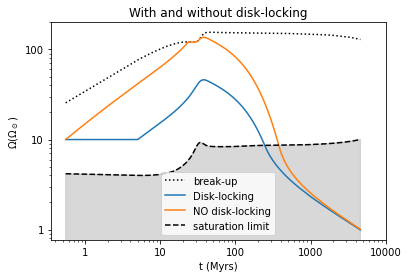

In [17]:
fig, ax = plt.subplots(figsize = (6,4))
plt.plot(withDiskLocking.t/1e6, withDiskLocking.Ocrit, 'k:', 
         label=r'break-up')
plt.plot(withDiskLocking.t/1e6, withDiskLocking.Omega, '-', 
         label=r'Disk-locking')
plt.plot(withoutDiskLocking.t/1e6, withoutDiskLocking.Omega, '-', 
         label=r'NO disk-locking')
ax.plot(withDiskLocking.t/1e6, withDiskLocking.Osat ,'k--', 
        label='saturation limit')
ax.fill_between(withDiskLocking.t/1e6, withDiskLocking.Osat, 
                0.*withDiskLocking.Osat, color='gray', alpha=0.3, zorder=0)
plt.ylabel('$\Omega(\Omega_\odot)$')
plt.xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])
ax.set_yticks([1, 10, 100])
ax.set_yticklabels([1, 10, 100])
ax.set_title('With and without disk-locking')

(2) To look at the structure vs wind components, this will help me plot each case:

In [14]:
def plot_decomposed_model(model, title='title', save=False):
    fig, ax = plt.subplots(figsize = (6,4))
    ax.plot(model.t/1e6, model.Ocrit, 'k:' ,label=r'break-up')
    ax.plot(model.t/1e6, model.Omega, '-', label=r'Model')
    ax.plot(model.t_w/1e6, model.Omega_w,'-', label=r'just wind')
    ax.plot(model.t_s/1e6, model.Omega_s,'-', label=r'just structure')
    ax.plot(model.t/1e6, model.Osat ,'k--', label='saturation limit')
    ax.fill_between(model.t/1e6, model.Osat, 0.*model.Osat, color='gray', 
                    alpha=0.3, zorder=0)    
    
    ax.set_ylabel('$\Omega(\Omega_\odot)$')
    ax.set_xlabel('t (Myrs)')
    plt.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_xticklabels([1, 10, 100, 1000, 10000])
    ax.set_yticks([1, 10, 100])
    ax.set_yticklabels([1, 10, 100])
    ax.set_title(title)
    if bool(save):
        plt.savefig('/Users/jroquette/work/plot/rotationevolutionmodel_test_'+
                    str(title)+'.png')

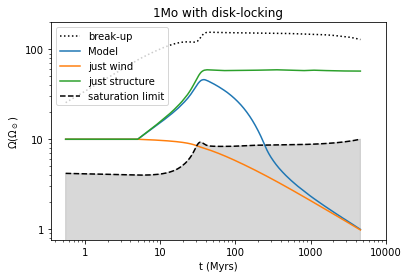

In [15]:
plot_decomposed_model(withDiskLocking, 
                      title='1Mo with disk-locking')

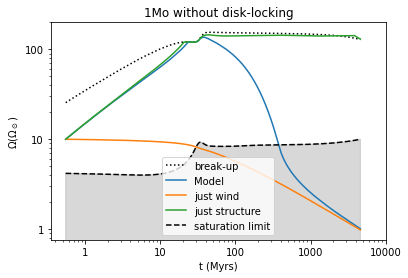

In [16]:
plot_decomposed_model(withoutDiskLocking, 
                      title='1Mo without disk-locking')

I can now look at the models for each of the masses in the disk-model. I will do that by using a median rotation of 5$\Omega_\odot$:

In [82]:
print(r' {0} OmegaSun is the same as {1} days'.format(5, 
                                        spinEvol.omega2period(5)))

 5 OmegaSun is the same as 5.594004012802338 days


In [83]:
disk.M[:-2]

array([0.1, 0.3, 0.5, 0.8, 1. , 1.3])

In [25]:
decomposed_models = {}
for m in disk.M[:-2]:
    decomposed_models[str(m)] = test_model(m, 5., spin, t, tau_d, e)

Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model


This warning is printed because the higher mass stars will evolve off the MS, and the Baraffe+15 model will no longer be available after some Gyrs. The only impact that this will bring to the models is that the model is only run until the maximum age of the Baraffe+15 model for the higher mass stars. For example:

In [85]:
decomposed_models['1.3'].t.max()/1e9

3.4058891252727546

It can be convenient to save the output of the models for later use. If this is notebook is being run in an OSx, I recommend using the `MacOSFile.py` function instead of `np.save`. This is required because of a bug in Python 3.4+ (that actually comes from Pickle 4+), where `np.save` crashes the file being saved is too long.  

In [15]:
import MacOSFile

In [3]:
mydir = '/Users/jroquette/work/data/SpinEvolutionModel_outputs/'

In [26]:
MacOSFile.pickle_dump(decomposed_models, mydir + 'decomposed_models.npy')

writing total_bytes=69905...
done.
writing total_bytes=68097...
done.
writing total_bytes=5094...
done.


In [16]:
decomposed_models = MacOSFile.pickle_load( mydir + 'decomposed_models.npy')

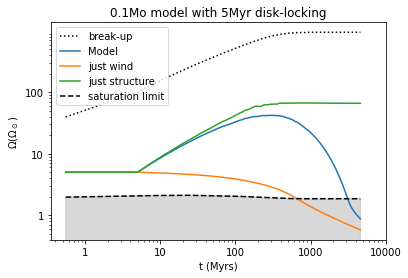

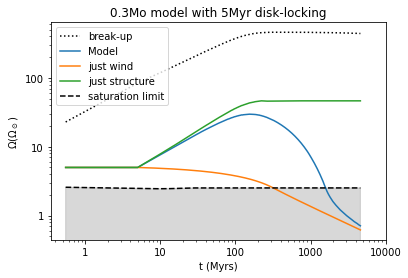

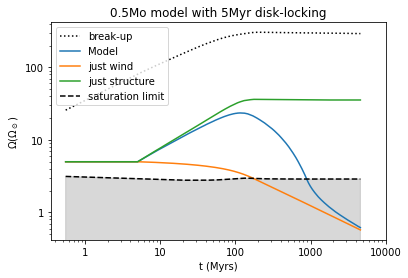

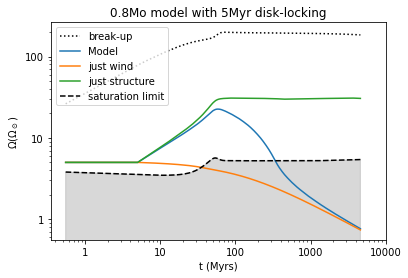

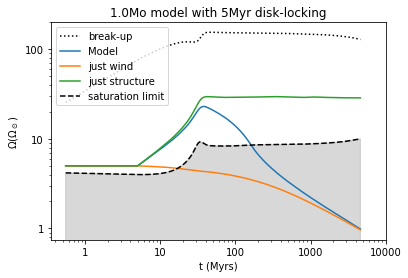

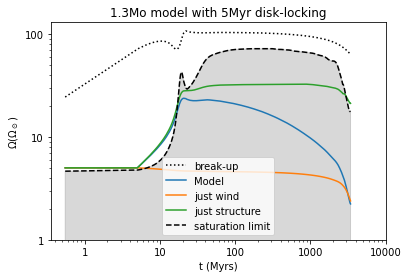

In [20]:
for m in disk.M[:-2]:
    plot_decomposed_model(decomposed_models[str(m)], title=str(m)+'Mo model with 5Myr disk-locking')

Text(0.5, 1.0, 'full models')

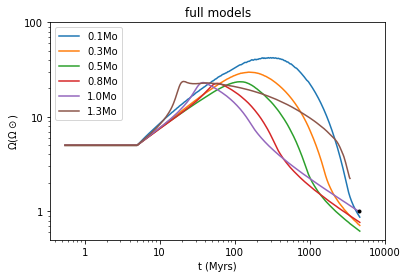

In [29]:
fig, ax = plt.subplots(figsize = (6,4))
for m in disk.M[:-2]:
    ax.plot(decomposed_models[str(m)].t/1e6, decomposed_models[str(m)].Omega,
            '-', label=str(m) + 'Mo')
ax.plot(4.55e9/1e6, 1, 'k.')
ax.set_ylabel('$\Omega(\Omega\odot)$')
ax.set_xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])
ax.set_yticks([1, 10, 100])
ax.set_yticklabels([1, 10, 100])
ax.set_title('full models')

Text(0.5, 1.0, 'just wind')

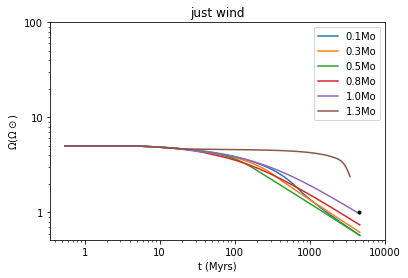

In [30]:
fig, ax = plt.subplots(figsize = (6,4))
for m in disk.M[:-2]:
    ax.plot(decomposed_models[str(m)].t_w/1e6, 
            decomposed_models[str(m)].Omega_w, '-', label=str(m) + 'Mo')
ax.plot(4.55e9/1e6, 1, 'k.')
ax.set_ylabel('$\Omega(\Omega\odot)$')
ax.set_xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])
ax.set_yticks([1, 10, 100])
ax.set_yticklabels([1, 10, 100])
ax.set_title('just wind')

Text(0.5, 1.0, 'just structure')

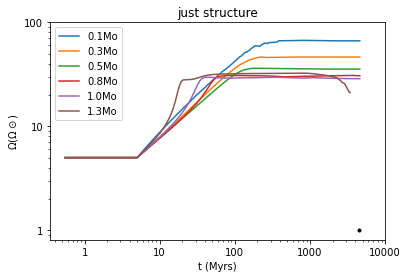

In [31]:
fig, ax = plt.subplots(figsize = (6,4))
for m in disk.M[:-2]:
    ax.plot(decomposed_models[str(m)].t_s/1e6, 
            decomposed_models[str(m)].Omega_s, '-', label=str(m) + 'Mo')
ax.plot(4.55e9/1e6, 1, 'k.')
ax.set_ylabel('$\Omega(\Omega\odot)$')
ax.set_xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])
ax.set_yticks([1, 10, 100])
ax.set_yticklabels([1, 10, 100])
ax.set_title('just structure')

### fast and slow-rotating models with FUV -> plots for the paper

Next, I want to look at the models influenced by the local-FUV flux. In the context of the paper, I am looking at a fast initial condition of 1.6 days and a slow initial condition of 16 days. 

In [17]:
fast = spinEvol.period2omega(1.6)
slow = spinEvol.period2omega(16.)

In [18]:
print('Omega: ', fast, slow, 'OmegaSun')

Omega:  17.481262540007307 1.7481262540007305 OmegaSun


The disk models are calculated for the following FUV-levels

In [19]:
disk.FUV

array([   10.,   100.,  1000.,  5000., 10000.])

To get the disk-dissipation timescale for a 1M$_\odot$ star, evolving under 100G$_0$ with a disk viscosity timescale of 1Myrs: 

~~(Note that results are returned in Myrs, while the spin evolution model will take `tau_d` in yrs!)~~ <- This was changed in the most recent version!

In [20]:
disk.get_tauD(1., 100., tau_vis=1)

10000000.0

Just to make it run faster, this creates a new `class` for getting the models, but this time without decomposing the models.

In [21]:
class fuv_model:
    """
    quick class that estimate models
    """
    def __init__(self, m, Oo, spin, t, tau_d, e):
        self.t, self.Omega = spin.dOmegadt(m, Oo, t, tau_d=tau_d, e=e)
        self.Ocrit=spin.get_BreakUp(m, self.t)
        self.Osat=spin.get_SaturationLimit(m, self.t)        

Here I am calculating models for $\tau_\mathrm{vis}$=1 Myrs, for every mass and FUV level:

In [14]:
fuv_models_vis_1Myr = {'fast': {}, 'slow': {}}
for m in disk.M[:-2]:
    fuv_models_vis_1Myr['fast'][str(m)]={}
    fuv_models_vis_1Myr['slow'][str(m)]={}        
    for fuv in disk.FUV:
        fuv_models_vis_1Myr['fast'][str(m)][str(fuv)] = fuv_model(m, fast, 
                                          spin_, t, disk.get_tauD(m, fuv), e)
        fuv_models_vis_1Myr['slow'][str(m)][str(fuv)] = fuv_model(m, slow, 
                                          spin_, t, disk.get_tauD(m, fuv), e)

/Users/jroquette/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Is $\tau_D$ in the right units?
Is $\tau_D$ in the right units?
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model


In [32]:
MacOSFile.pickle_dump(fuv_models_vis_1Myr, mydir + 'fuv_models.npy')

writing total_bytes=71715...
done.
writing total_bytes=72648...
done.
writing total_bytes=66457...
done.
writing total_bytes=68527...
done.
writing total_bytes=70229...
done.
writing total_bytes=66726...
done.
writing total_bytes=70327...
done.
writing total_bytes=71032...
done.
writing total_bytes=67286...
done.
writing total_bytes=67701...
done.
writing total_bytes=71213...
done.
writing total_bytes=66034...
done.
writing total_bytes=65711...
done.
writing total_bytes=68064...
done.
writing total_bytes=65736...
done.
writing total_bytes=66076...
done.
writing total_bytes=66864...
done.
writing total_bytes=10912...
done.


In [22]:
fuv_models_vis_1Myr = MacOSFile.pickle_load(mydir + 'fuv_models.npy')

`FUVfunctions` includes a colour-table defined to represent the FUV levels in all the plots.

In [23]:
from fire.FUVfunctions import cmapFUV, normFUV, plotCmapFUV
import matplotlib as mpl

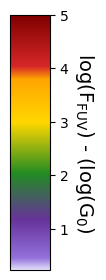

In [24]:
plotCmapFUV()

This function helps to plot inside the same plot the models for the same mass at different FUV levels.

In [47]:
def plot_pair(m, model, title='title', save=False):
    model_f = model['fast'][str(m)]
    model_s = model['slow'][str(m)]    
    fig, ax = plt.subplots(figsize = (6,4))
    for fuv in disk.FUV:
        color = cmapFUV(normFUV(np.log10(fuv)))
        ax.plot(model_f[str(fuv)].t/1e6, model_f[str(fuv)].Omega, '-', 
                color=color, label=str(int(fuv)) + 'G0')
        ax.plot(model_s[str(fuv)].t/1e6, model_s[str(fuv)].Omega, '--', 
                color=color) 
    ax.plot(model_f[str(fuv)].t/1e6, model_f[str(fuv)].Ocrit, 'k:', 
            label=r'break-up')        
    ax.plot(model_f[str(fuv)].t/1e6, model_f[str(fuv)].Osat ,'k--', 
            label='saturation limit')
    ax.fill_between(model_f[str(fuv)].t/1e6, model_f[str(fuv)].Osat, 
                  0.*model_f[str(fuv)].Osat, color='gray', alpha=0.3,zorder=0)
    ax.set_ylabel('$\Omega(\Omega\odot)$')
    ax.seT_xlabel('t (Myrs)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_xticklabels([1, 10, 100, 1000, 10000])
    ax.set_yticks([1, 10, 100])
    ax.set_yticklabels([1, 10, 100])
    ax.set_title(title)
    if bool(save):
        plt.savefig(mydir + 'rotationevolutionmodel_test_'+str(title)+'.png')

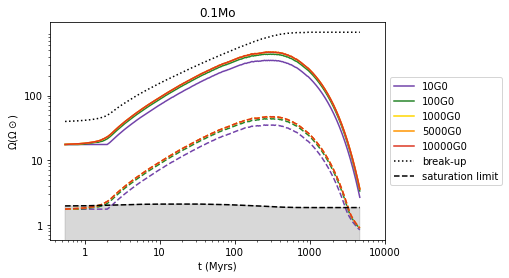

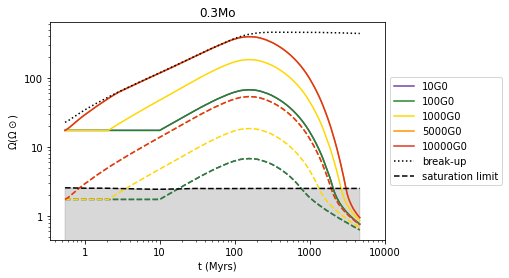

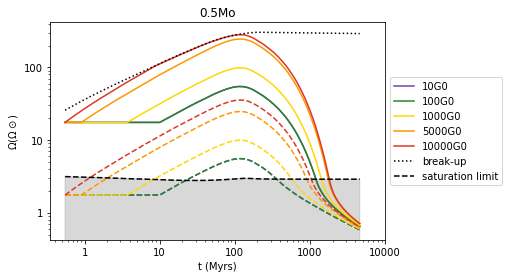

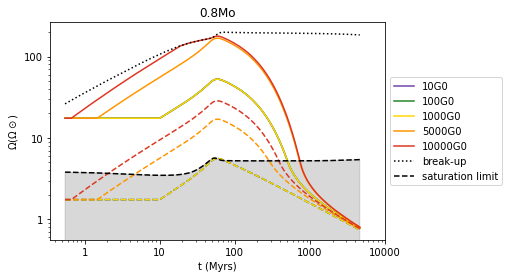

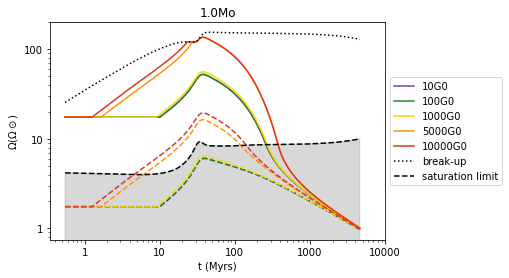

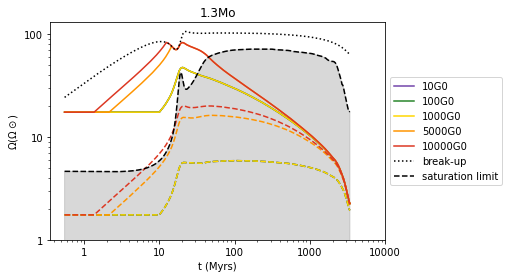

In [50]:
for m in disk.M[:-2]:
    plot_pair(m,fuv_models_vis_1Myr, title=str(m) + 'Mo')

This needs to be also run for the other $\tau_\mathrm{vis}$:

In [57]:
fuv_models_vis_2Myr = {'fast': {}, 'slow': {}}
for m in disk.M[:-2]:
    fuv_models_vis_2Myr['fast'][str(m)]={}
    fuv_models_vis_2Myr['slow'][str(m)]={}        
    for fuv in disk.FUV:
        fuv_models_vis_2Myr['fast'][str(m)][str(fuv)] = fuv_model(m, fast, 
                               spin_, t, disk.get_tauD(m, fuv, tau_vis=2.), e)
        fuv_models_vis_2Myr['slow'][str(m)][str(fuv)] = fuv_model(m, slow, 
                               spin_, t, disk.get_tauD(m, fuv, tau_vis=2.), e)

/Users/jroquette/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Is $\tau_D$ in the right units?
Is $\tau_D$ in the right units?
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model


In [58]:
fuv_models_vis_5Myr = {'fast': {}, 'slow': {}}
for m in disk.M[:-2]:
    fuv_models_vis_5Myr['fast'][str(m)]={}
    fuv_models_vis_5Myr['slow'][str(m)]={}        
    for fuv in disk.FUV:
        fuv_models_vis_5Myr['fast'][str(m)][str(fuv)] = fuv_model(m, fast, 
                               spin_, t, disk.get_tauD(m, fuv, tau_vis=5.), e)
        fuv_models_vis_5Myr['slow'][str(m)][str(fuv)] = fuv_model(m, slow,
                               spin_, t, disk.get_tauD(m, fuv, tau_vis=5.), e)

Is $\tau_D$ in the right units?
Is $\tau_D$ in the right units?
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model


Saving these models:

In [59]:
MacOSFile.pickle_dump(fuv_models_vis_2Myr, mydir + 'fuv_models_2Myr.npy')
MacOSFile.pickle_dump(fuv_models_vis_5Myr, mydir + 'fuv_models_5Myr.npy')

writing total_bytes=69123...
done.
writing total_bytes=72616...
done.
writing total_bytes=71256...
done.
writing total_bytes=69496...
done.
writing total_bytes=70645...
done.
writing total_bytes=65562...
done.
writing total_bytes=67507...
done.
writing total_bytes=67760...
done.
writing total_bytes=66793...
done.
writing total_bytes=68464...
done.
writing total_bytes=71367...
done.
writing total_bytes=69276...
done.
writing total_bytes=66018...
done.
writing total_bytes=67510...
done.
writing total_bytes=65724...
done.
writing total_bytes=67069...
done.
writing total_bytes=34119...
done.
writing total_bytes=70551...
done.
writing total_bytes=70371...
done.
writing total_bytes=69621...
done.
writing total_bytes=69798...
done.
writing total_bytes=72183...
done.
writing total_bytes=68161...
done.
writing total_bytes=67073...
done.
writing total_bytes=66131...
done.
writing total_bytes=66932...
done.
writing total_bytes=65968...
done.
writing total_bytes=68843...
done.
writing total_bytes=

Reloading them:

In [25]:
fuv_models_vis_2Myr = MacOSFile.pickle_load(mydir + 'fuv_models_2Myr.npy')
fuv_models_vis_5Myr = MacOSFile.pickle_load(mydir + 'fuv_models_5Myr.npy')

In [26]:
disk.FUV


array([   10.,   100.,  1000.,  5000., 10000.])

<ipython-input-106-c95023e162fa>:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale("log")
<ipython-input-106-c95023e162fa>:34: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


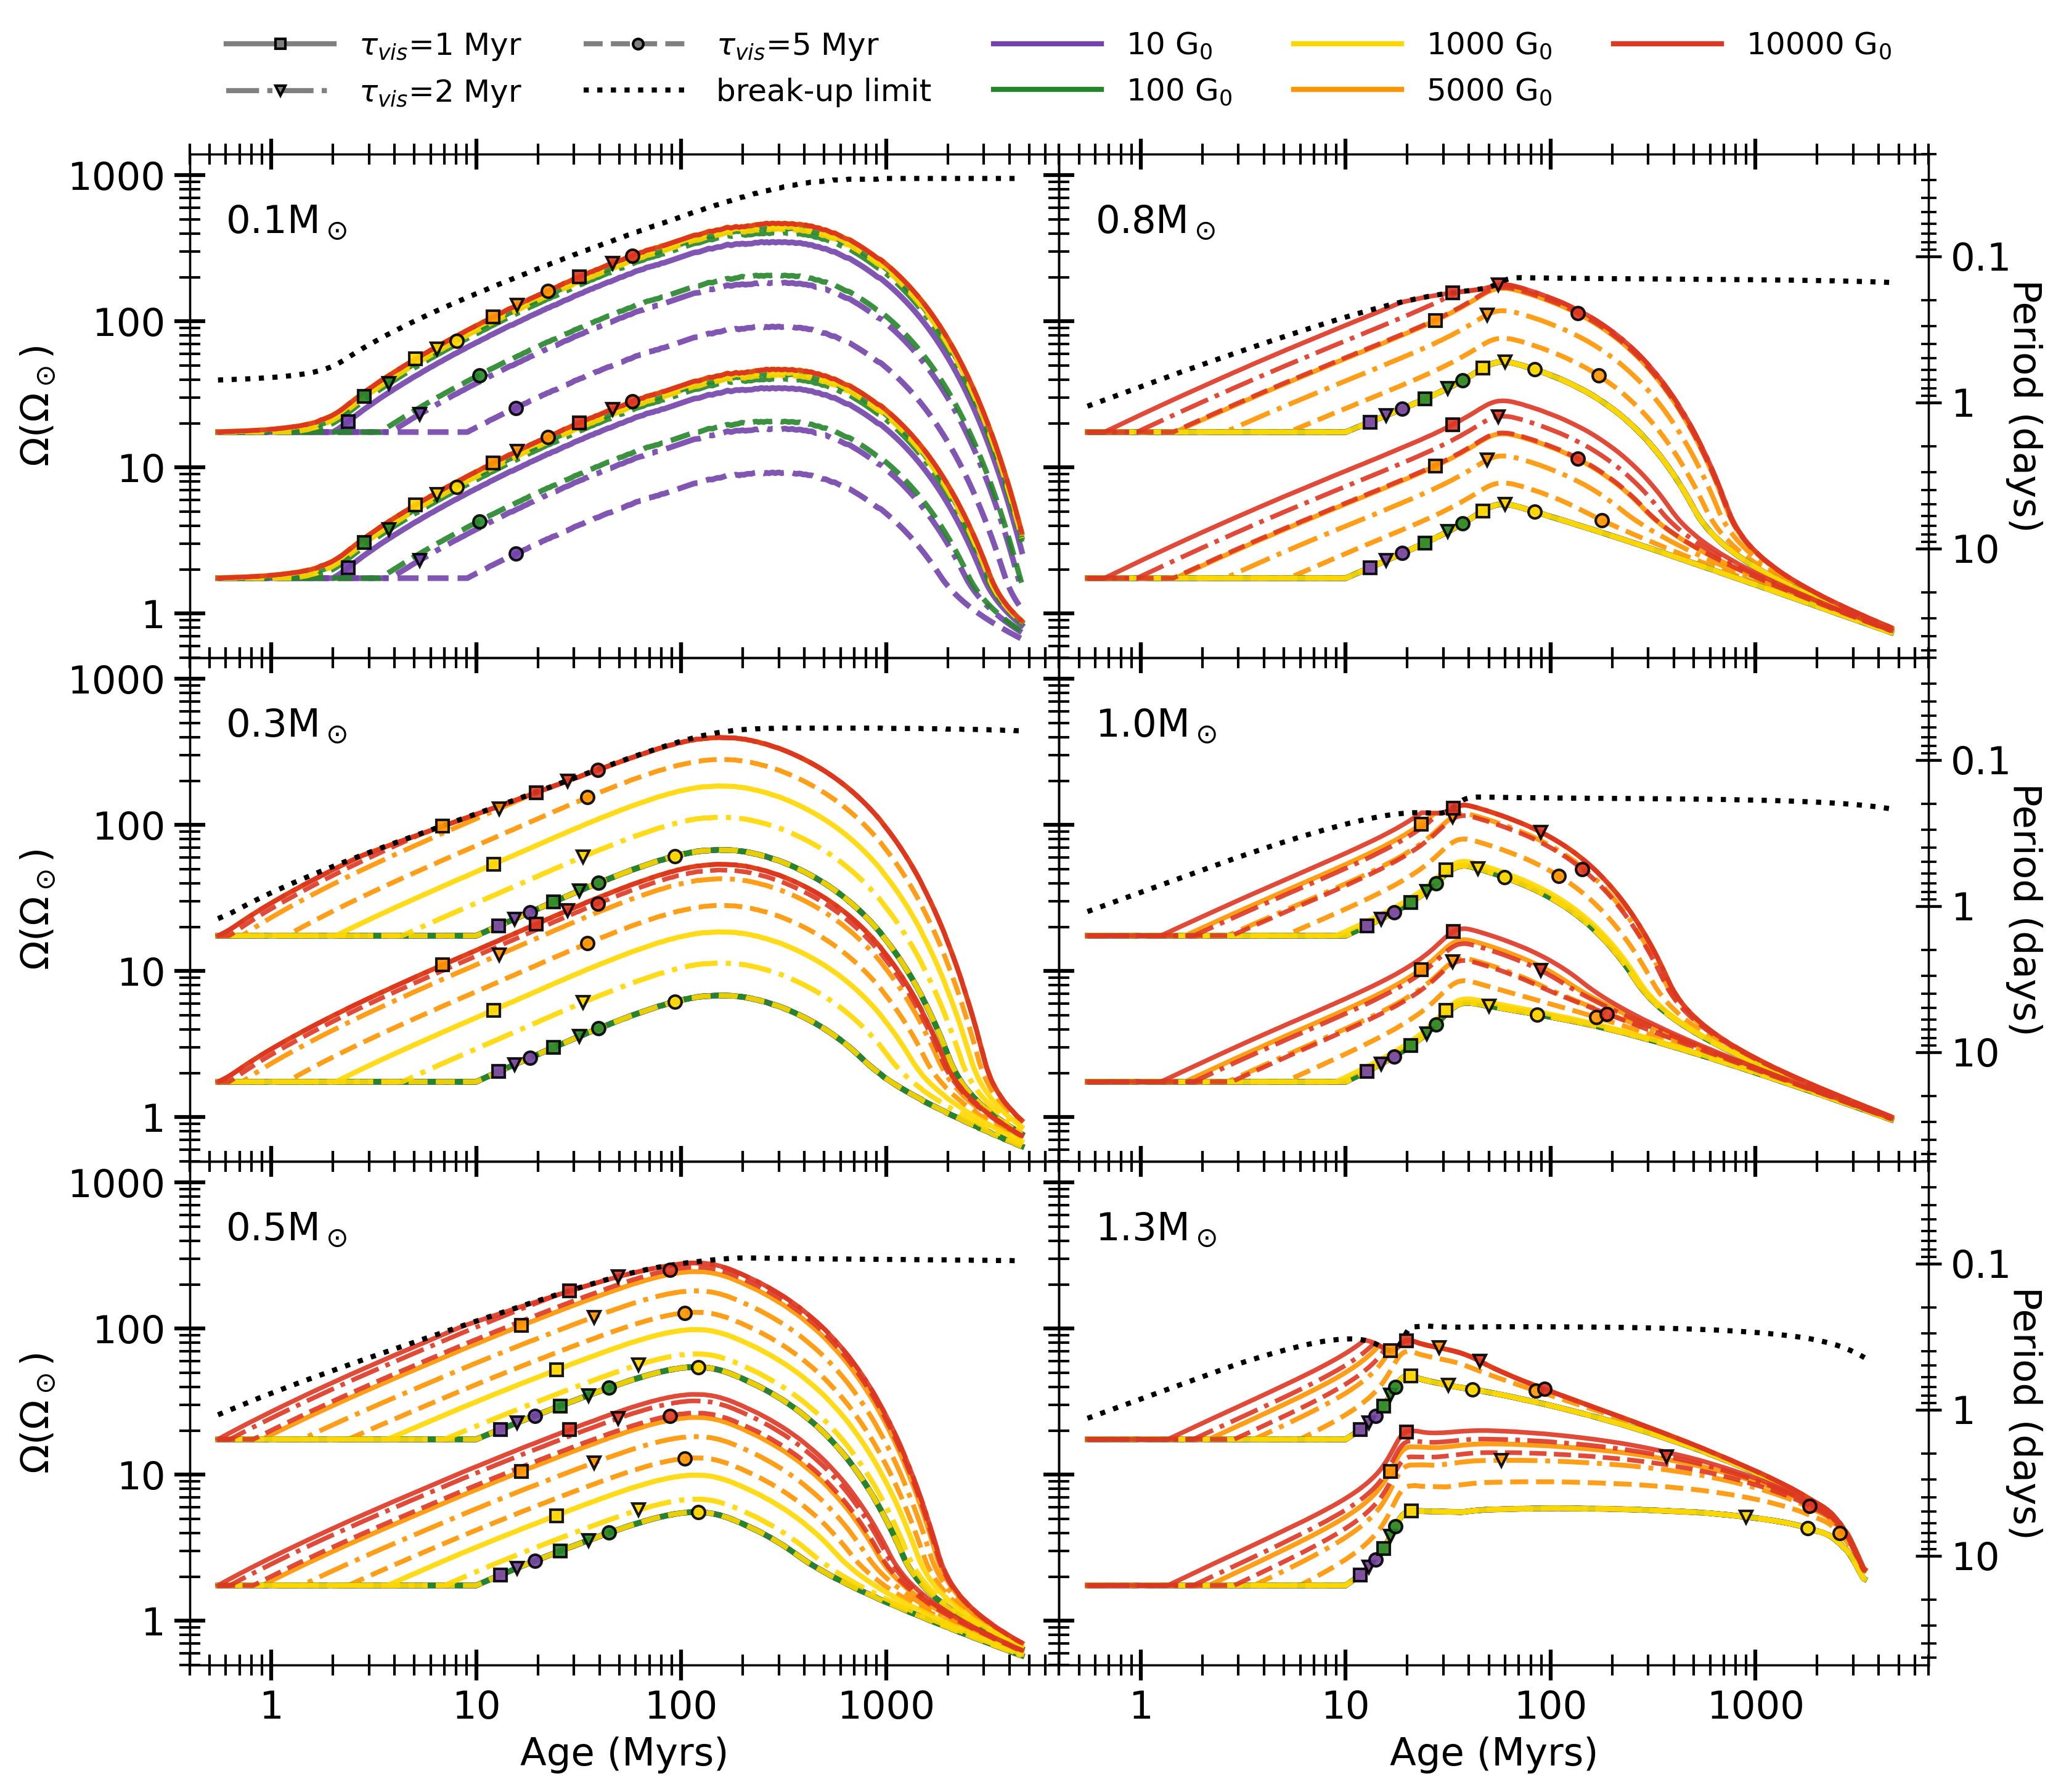

In [106]:
import matplotlib.ticker as mticker
fig,axis= plt.subplots(3, 2, figsize=(11, 9.5), dpi=300, sharex=True, 
                       sharey=True)
plt.subplots_adjust(wspace=0., hspace=0)
plt.subplots_adjust(left=0.085, right=0.94, bottom=0.07, top=0.93)

fs = 15
ax = axis[0]
zorder = [0, 1, 2, 0, 2]
lw = [2.2, 2.1, 2, 1.9, 1.8]
sy = ['s', 'v', 'o']
li = ['-', '-.', '--']
alpha = 0.9
j = np.array([[18, 60, 120, 190, 260], [30, 80, 138, 210, 285], [42, 95, 150,\
                                                                 235, 300]])
ai = [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1)]

axis[0, 0].plot([-10, -20], [-10, -20], 's', ls='-', lw=2, color='gray', 
                label=r'$\tau_{vis}$=1 Myr', zorder=0, markeredgecolor='k', 
                ms=4)
axis[0, 0].plot([-10, -20], [-10, -20], 'v', ls='-.', lw=2, color='gray', 
                label=r'$\tau_{vis}$=2 Myr', zorder=0, markeredgecolor='k',
                ms=4)
axis[0, 0].plot([-10, -20], [-10, -20], 'o', ls='--', lw=2, color='gray',
                label=r'$\tau_{vis}$=5 Myr',zorder=0, markeredgecolor='k',
                ms=4)        
color = []
for i, fuv in enumerate(disk.FUV):
    color.append(cmapFUV(normFUV(np.log10(fuv))))

for i, mass in enumerate(disk.M[:-2]):
    ax = axis[ai[i]]
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_yscale("log")
    ax2.set_xscale("log")    
    ax.text(0.6, 400, str(mass) + r'$\mathrm{M}_\odot$', fontsize=fs)
    ax.set_yticks([1, 10, 100, 1000])
    ax.set_yticklabels([1, 10, 100, 1000], fontsize=fs)  
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_xticklabels([1, 10, 100, 1000, ''], fontsize=fs)    
    ax2.set_yticks([0.1, 1, 10, 100, 1000])
    ax2.set_yticklabels([0.1, 1, 10, 100, 1000], fontsize=fs)
    for ax_ in [ax, ax2]:
        for xx in ['x', 'y']:
            ax_.tick_params(axis=xx, direction="inout", length=12, width=1.5,
                            top=True)    
            ax.tick_params(axis=xx, which='minor', direction="inout", 
                           length=8, width=1, top=True)    
    if ai[i][1] == 0:
        ax2.set_yticklabels(['', '', '', '', ''], fontsize=fs)  
        ax.set_ylabel('$\Omega(\Omega_\odot)$', fontsize=fs)
        ax2.tick_params(axis="y", direction="inout", length=0, width=1.1)
        ax2.tick_params(axis="y", which='minor', direction="inout", length=0, 
                        width=0.9)        
    else:
        ax2.set_ylabel('Period (days)', fontsize=fs, rotation=-90, 
                       labelpad=12)
        ax2.tick_params(axis="y", direction="inout", length=10, width=1.1)
        ax2.tick_params(axis="y", which='minor', direction="inout", length=6, 
                        width=0.9)
    ax.set_xlim(0.4, 0.7e4)    
    ax2.set_ylim(spinEvol.omega2period(0.5), spinEvol.omega2period(1400))      
    for f,fuv in enumerate(disk.FUV):
        for k, model in enumerate([fuv_models_vis_1Myr, fuv_models_vis_2Myr, 
                                   fuv_models_vis_5Myr]):
            for speed in ["fast", "slow"]:
                mod = model[speed][str(mass)][str(fuv)]
                ax.plot(mod.t/1e6, mod.Omega, li[k], color=color[f], lw=lw[f],
                        zorder=zorder[f], alpha=alpha)
                ax.plot(mod.t[j[k,f]]/1e6, mod.Omega[j[k,f]], sy[k], ms=5, 
                        color=color[f], zorder=5, alpha=alpha, 
                        markeredgecolor='k') 
    ax.plot(mod.t/1e6, mod.Ocrit, 'k:', label=r'break-up limit', lw=2)     
    if ai[i][0] == 2:
        ax.set_xlabel('Age (Myrs)', fontsize=fs)
#forces the break-up limit key to come first
for i, fuv in enumerate(disk.FUV):
    axis[0, 0].plot([-1, -1.1], [-1., -1.1], lw=2, color=color[i], label=
                    r"{0} G$_0$".format(int(fuv)), linestyle='-')        
        
ax.set_ylim(0.5, 1400)

leg = axis[0, 0].legend(handlelength=3.5, ncol=5, fontsize=12, 
                        loc="upper center", bbox_to_anchor=(1,1.3))
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')
        

name = 'Omega_Age_model_FUVcolored_MaxMinRotation_differentTau_1p6to16d.png'
plt.savefig(mydir + name)

<ipython-input-103-7f05183e0fb0>:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale("log")
<ipython-input-103-7f05183e0fb0>:34: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


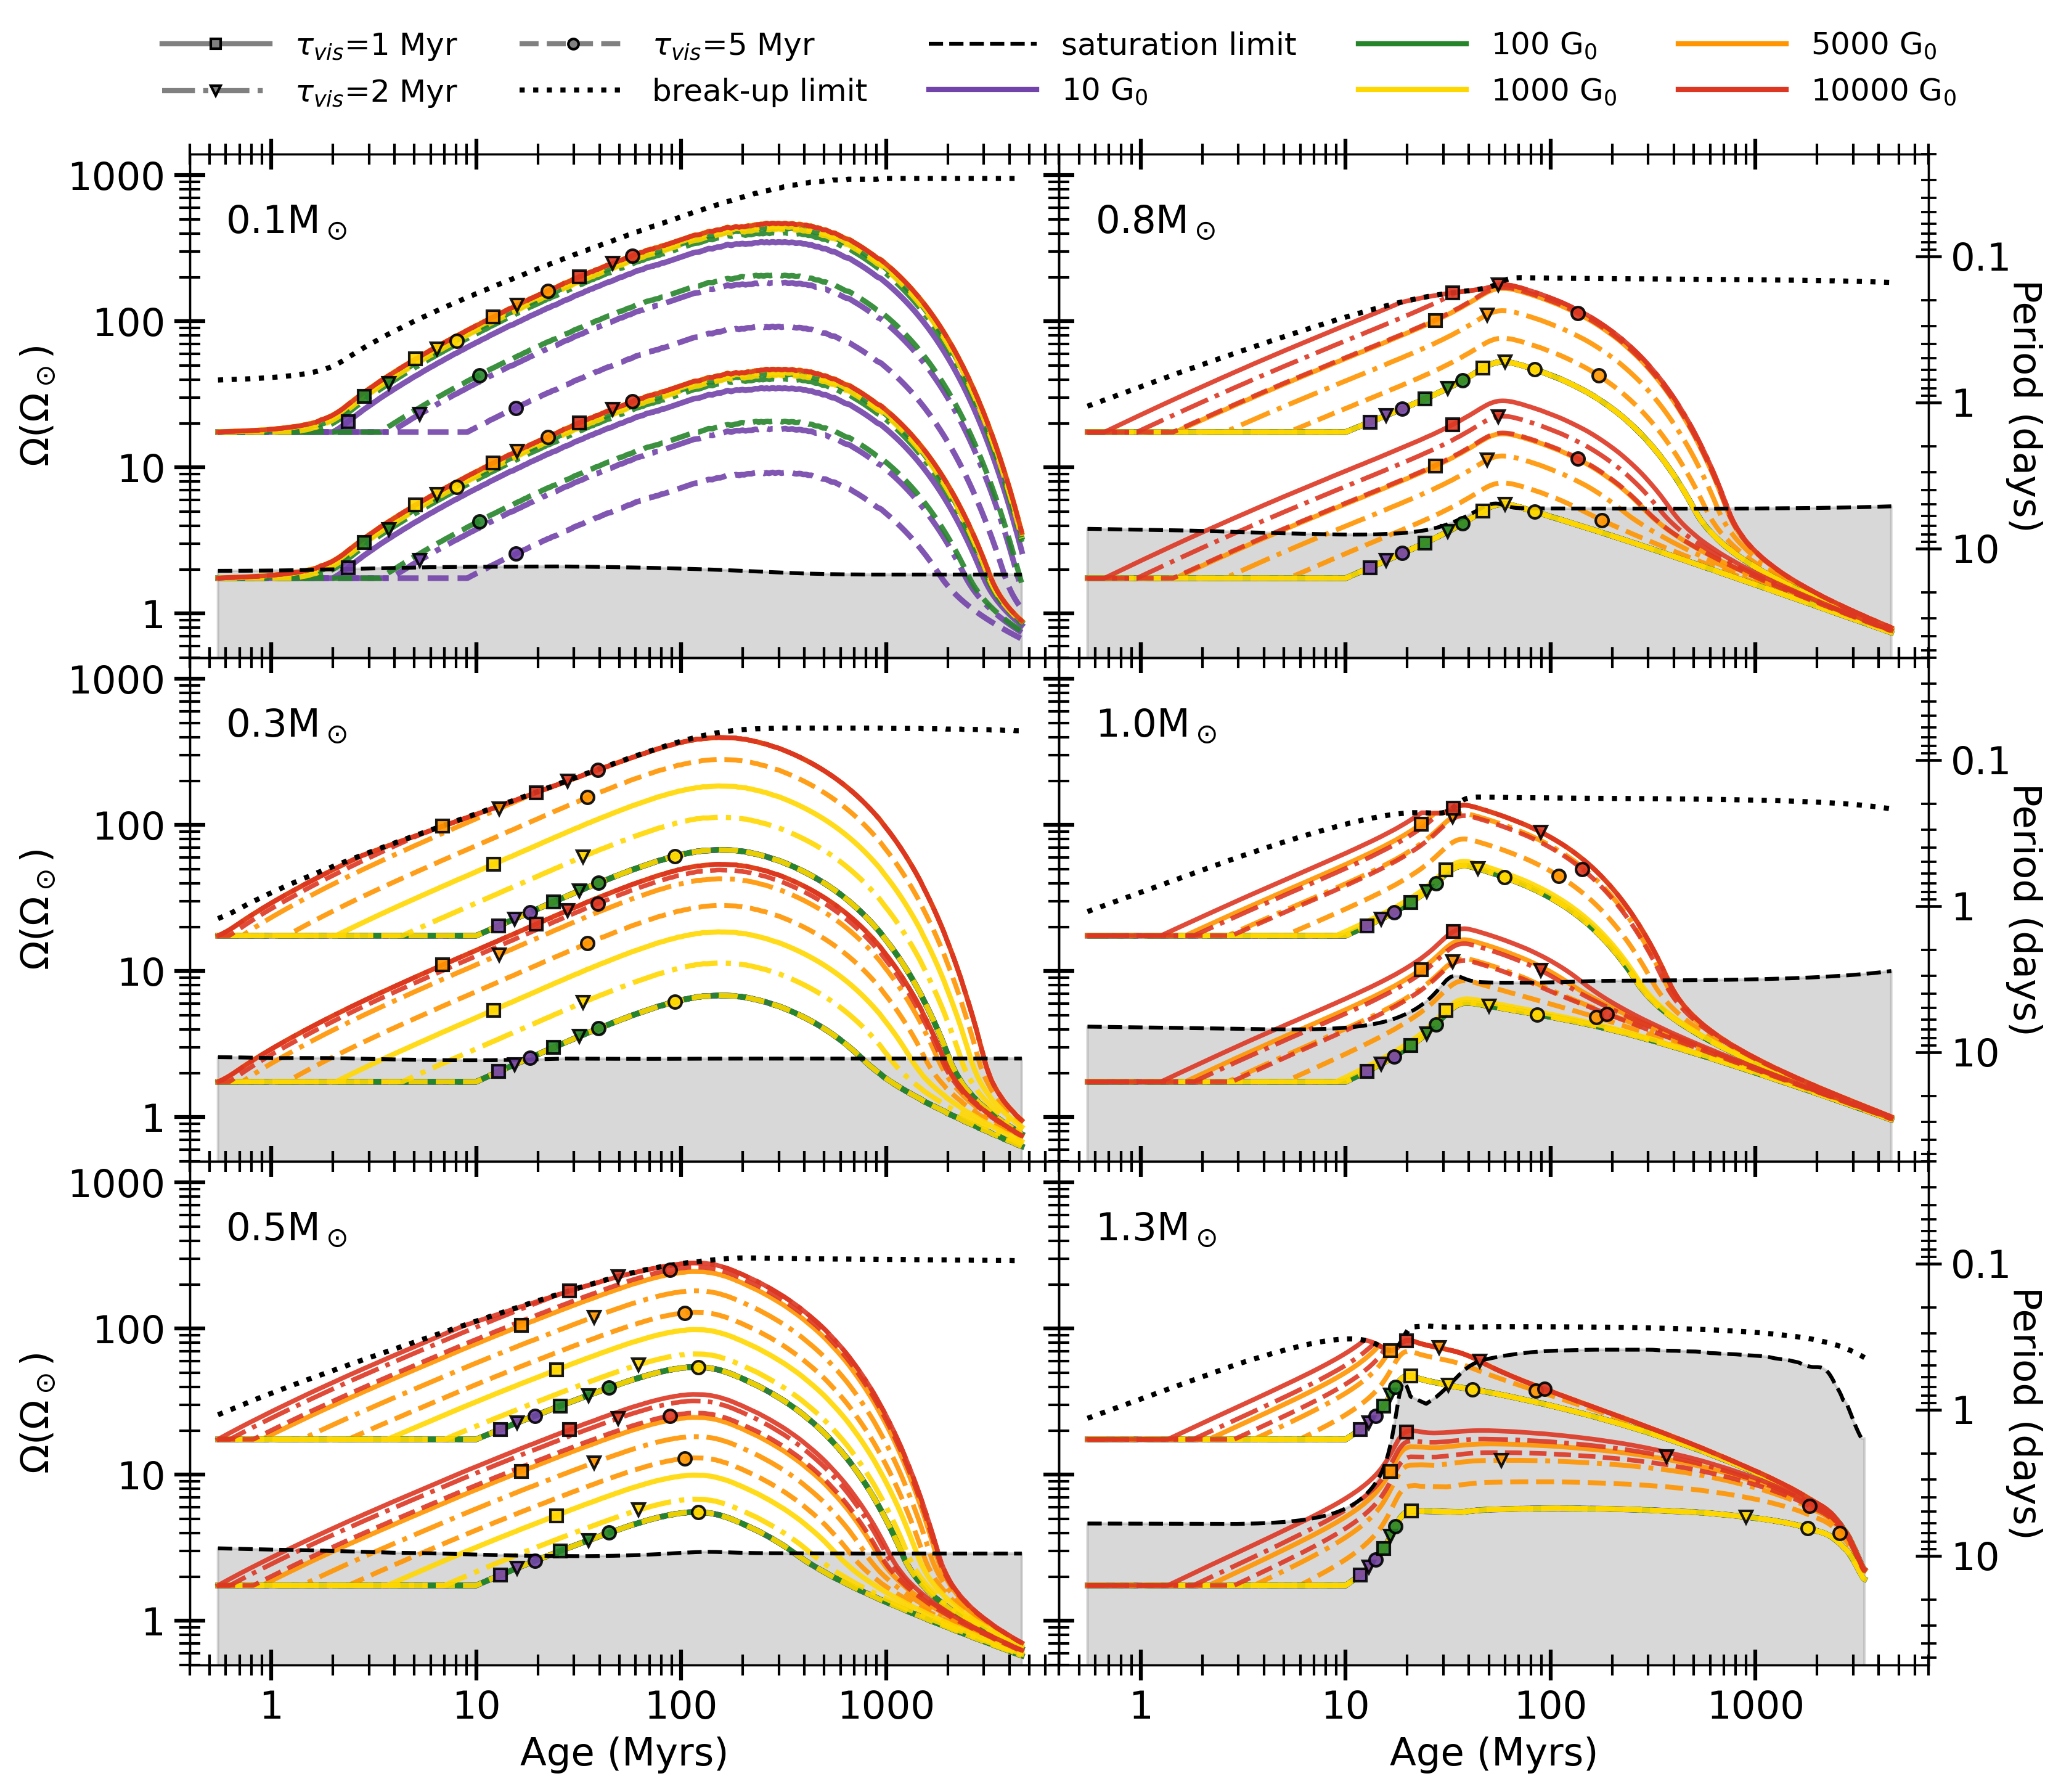

In [103]:
import matplotlib.ticker as mticker
fig,axis= plt.subplots(3, 2, figsize=(11, 9.5), dpi=300, sharex=True, 
                       sharey=True)
plt.subplots_adjust(wspace=0., hspace=0)
plt.subplots_adjust(left=0.085, right=0.94, bottom=0.07, top=0.93)

fs = 15
ax = axis[0]
zorder = [0, 1, 2, 0, 2]
lw = [2.2, 2.1, 2, 1.9, 1.8]
sy = ['s', 'v', 'o']
li = ['-', '-.', '--']
alpha = 0.9
j = np.array([[18, 60, 120, 190, 260], [30, 80, 138, 210, 285], [42, 95, 150,\
                                                                 235, 300]])
ai = [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1)]

axis[0, 0].plot([-10, -20], [-10, -20], 's', ls='-', lw=2, color='gray', 
                label=r'$\tau_{vis}$=1 Myr', zorder=0, markeredgecolor='k', 
                ms=4)
axis[0, 0].plot([-10, -20], [-10, -20], 'v', ls='-.', lw=2, color='gray', 
                label=r'$\tau_{vis}$=2 Myr', zorder=0, markeredgecolor='k',
                ms=4)
axis[0, 0].plot([-10, -20], [-10, -20], 'o', ls='--', lw=2, color='gray',
                label=r'$\tau_{vis}$=5 Myr',zorder=0, markeredgecolor='k',
                ms=4)        
color = []
for i, fuv in enumerate(disk.FUV):
    color.append(cmapFUV(normFUV(np.log10(fuv))))

for i, mass in enumerate(disk.M[:-2]):
    ax = axis[ai[i]]
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_yscale("log")
    ax2.set_xscale("log")    
    ax.text(0.6, 400, str(mass) + r'$\mathrm{M}_\odot$', fontsize=fs)
    ax.set_yticks([1, 10, 100, 1000])
    ax.set_yticklabels([1, 10, 100, 1000], fontsize=fs)  
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_xticklabels([1, 10, 100, 1000, ''], fontsize=fs)    
    ax2.set_yticks([0.1, 1, 10, 100, 1000])
    ax2.set_yticklabels([0.1, 1, 10, 100, 1000], fontsize=fs)
    for ax_ in [ax, ax2]:
        for xx in ['x', 'y']:
            ax_.tick_params(axis=xx, direction="inout", length=12, width=1.5,
                            top=True)    
            ax.tick_params(axis=xx, which='minor', direction="inout", 
                           length=8, width=1, top=True)    
    if ai[i][1] == 0:
        ax2.set_yticklabels(['', '', '', '', ''], fontsize=fs)  
        ax.set_ylabel('$\Omega(\Omega_\odot)$', fontsize=fs)
        ax2.tick_params(axis="y", direction="inout", length=0, width=1.1)
        ax2.tick_params(axis="y", which='minor', direction="inout", length=0, 
                        width=0.9)        
    else:
        ax2.set_ylabel('Period (days)', fontsize=fs, rotation=-90, 
                       labelpad=12)
        ax2.tick_params(axis="y", direction="inout", length=10, width=1.1)
        ax2.tick_params(axis="y", which='minor', direction="inout", length=6, 
                        width=0.9)
    ax.set_xlim(0.4, 0.7e4)    
    ax2.set_ylim(spinEvol.omega2period(0.5), spinEvol.omega2period(1400))      
    for f,fuv in enumerate(disk.FUV):
        for k, model in enumerate([fuv_models_vis_1Myr, fuv_models_vis_2Myr, 
                                   fuv_models_vis_5Myr]):
            for speed in ["fast", "slow"]:
                mod = model[speed][str(mass)][str(fuv)]
                ax.plot(mod.t/1e6, mod.Omega, li[k], color=color[f], lw=lw[f],
                        zorder=zorder[f], alpha=alpha)
                ax.plot(mod.t[j[k,f]]/1e6, mod.Omega[j[k,f]], sy[k], ms=5, 
                        color=color[f], zorder=5, alpha=alpha, 
                        markeredgecolor='k') 
    ax.plot(mod.t/1e6, mod.Ocrit, 'k:', label=r'break-up limit', lw=2)     
    ax.plot(mod.t/1e6, mod.Osat ,'k--', label='saturation limit')
    ax.fill_between(mod.t/1e6, mod.Osat, 0.*mod.Osat, color='gray', alpha=0.3,
                     zorder=0)        

    if ai[i][0] == 2:
        ax.set_xlabel('Age (Myrs)', fontsize=fs)
#forces the break-up limit key to come first
for i, fuv in enumerate(disk.FUV):
    axis[0, 0].plot([-1, -1.1], [-1., -1.1], lw=2, color=color[i], label=
                    r"{0} G$_0$".format(int(fuv)), linestyle='-')        
        
ax.set_ylim(0.5, 1400)

leg = axis[0, 0].legend(handlelength=3.5, ncol=5, fontsize=12, 
                        loc="upper center", bbox_to_anchor=(1,1.3))
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')

name = 'Omega_Age_model_FUVcolored_MaxMinRotation_differentTau_1p6to16d_withSaturationLimit.png'
plt.savefig(mydir + name)

### plot with MNRAS standard

Figure 3 in the paper, following the [MNRSAS guidelines](https://academic.oup.com/mnras/pages/General_Instructions).

<ipython-input-46-d68eec6b57ee>:38: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale("log")
<ipython-input-46-d68eec6b57ee>:39: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


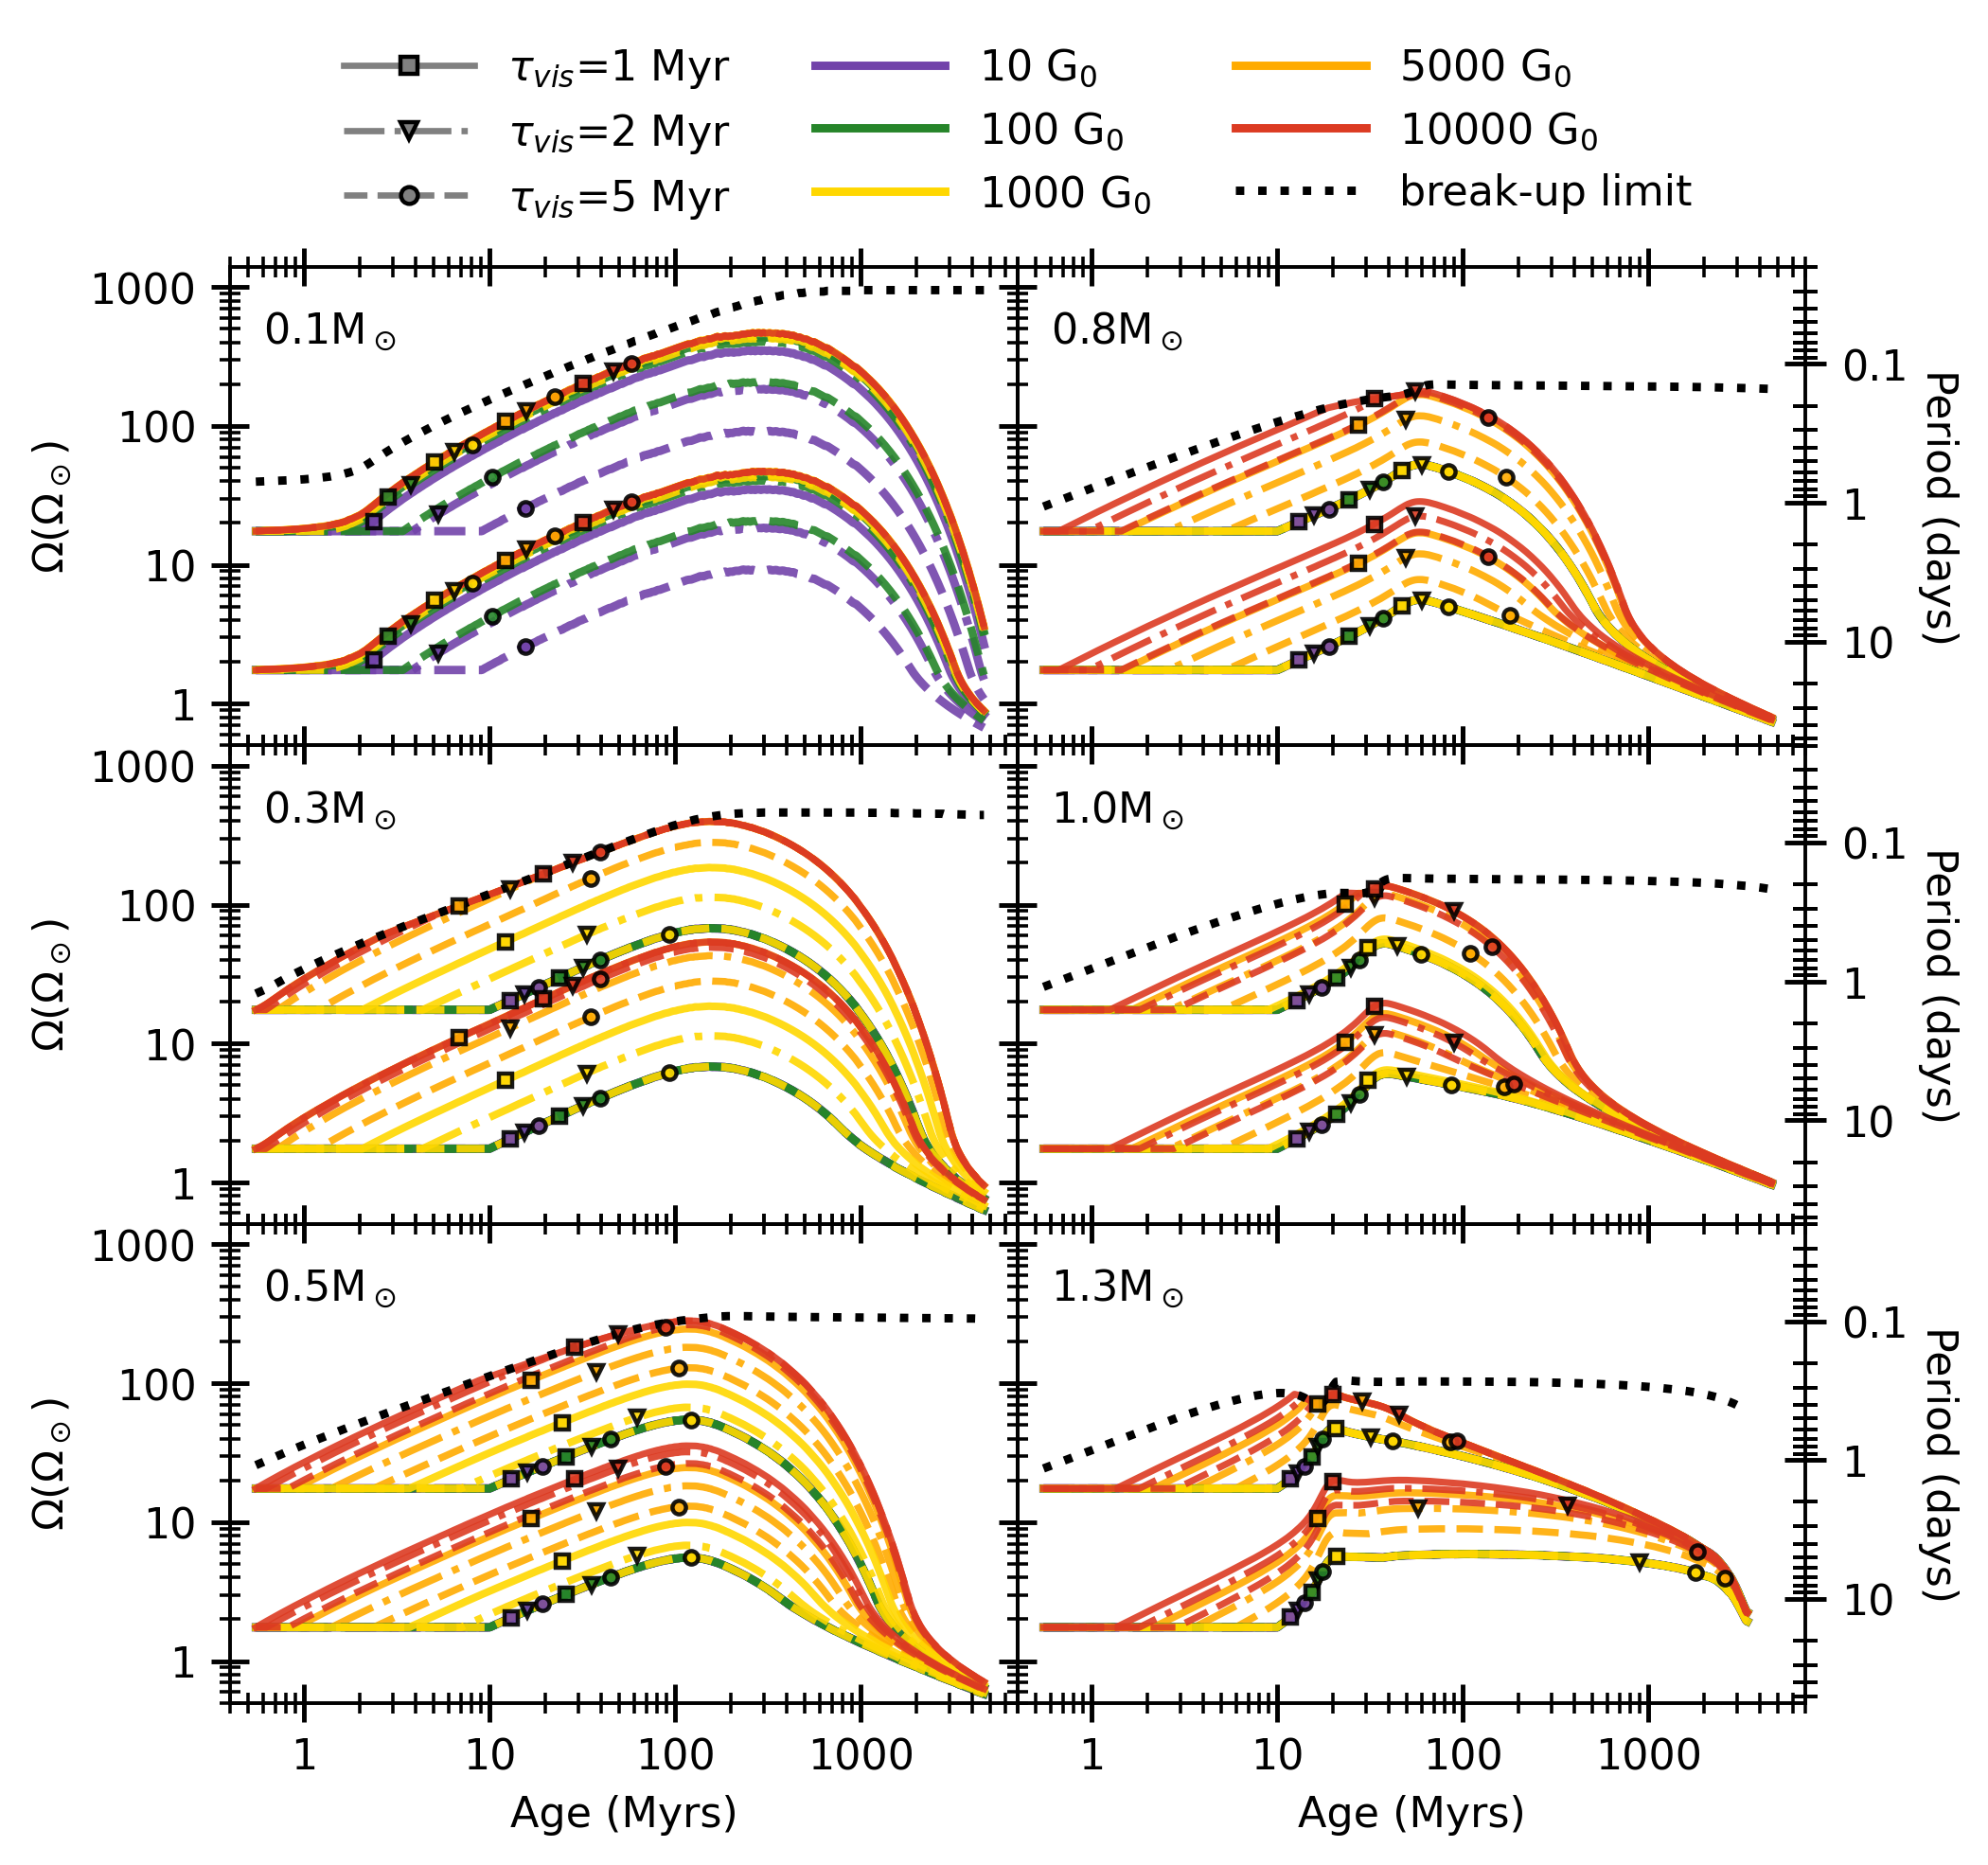

In [46]:
import matplotlib.ticker as mticker
fig,axis= plt.subplots(3, 2, figsize=(6.5, 6), dpi=320, sharex=True, 
                       sharey=True)
plt.subplots_adjust(wspace=0., hspace=0)
plt.subplots_adjust(left=0.11, right=0.91, bottom=0.08, top=0.87)

fs = 10
ax = axis[0]
zorder = [0, 1, 2, 0, 2]
lw = [2., 1.9, 1.8, 1.7, 1.6]
sy = ['s', 'v', 'o']
li = ['-', '-.', '--']
alpha = 0.9
ms = 3.2
j = np.array([[18, 60, 120, 190, 260], [30, 80, 138, 210, 285], [42, 95, 150,\
                                                                 235, 300]])
ai = [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1)]

axis[0, 0].plot([-10, -20], [-10, -20], 's', ls='-', lw=1.5, color='gray', 
                label=r'$\tau_{vis}$=1 Myr', zorder=0, markeredgecolor='k', 
                ms=4)
axis[0, 0].plot([-10, -20], [-10, -20], 'v', ls='-.', lw=1.5, color='gray', 
                label=r'$\tau_{vis}$=2 Myr', zorder=0, markeredgecolor='k',
                ms=4)
axis[0, 0].plot([-10, -20], [-10, -20], 'o', ls='--', lw=1.5, color='gray',
                label=r'$\tau_{vis}$=5 Myr',zorder=0, markeredgecolor='k',
                ms=4)        
color = []
for i, fuv in enumerate(disk.FUV):
    color.append(cmapFUV(normFUV(np.log10(fuv))))
for i, fuv in enumerate(disk.FUV):
    axis[0, 0].plot([-1, -1.1], [-1., -1.1], lw=2, color=color[i], label=
                    r"{0} G$_0$".format(int(fuv)), linestyle='-')        
        

for i, mass in enumerate(disk.M[:-2]):
    ax = axis[ai[i]]
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_yscale("log")
    ax2.set_xscale("log")    
    ax.text(0.6, 400, str(mass) + r'$\mathrm{M}_\odot$', fontsize=fs)
    ax.set_yticks([1, 10, 100, 1000])
    ax.set_yticklabels([1, 10, 100, 1000], fontsize=fs)  
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_xticklabels([1, 10, 100, 1000, ''], fontsize=fs)    
    ax2.set_yticks([0.1, 1, 10, 100, 1000])
    ax2.set_yticklabels([0.1, 1, 10, 100, 1000], fontsize=fs)
    for ax_ in [ax, ax2]:
        for xx in ['x', 'y']:
            ax_.tick_params(axis=xx, direction="inout", length=9, width=1.1,
                            top=True)    
            ax.tick_params(axis=xx, which='minor', direction="inout", 
                           length=5, width=0.8, top=True)    
    if ai[i][1] == 0:
        ax2.set_yticklabels(['', '', '', '', ''], fontsize=fs)  
        ax.set_ylabel('$\Omega(\Omega_\odot)$', fontsize=fs)
        ax2.tick_params(axis="y", direction="inout", length=0, width=1.1)
        ax2.tick_params(axis="y", which='minor', direction="inout", length=0, 
                        width=0.9)        
    else:
        ax2.set_ylabel('Period (days)', fontsize=fs, rotation=-90, 
                       labelpad=12)
        ax2.tick_params(axis="y", direction="inout", length=10, width=1.1)
        ax2.tick_params(axis="y", which='minor', direction="inout", length=6, 
                        width=0.9)
    ax.set_xlim(0.4, 0.7e4)    
    ax2.set_ylim(spinEvol.omega2period(0.5), spinEvol.omega2period(1400))      
    for f,fuv in enumerate(disk.FUV):
        for k, model in enumerate([fuv_models_vis_1Myr, fuv_models_vis_2Myr, 
                                   fuv_models_vis_5Myr]):
            for speed in ["fast", "slow"]:
                mod = model[speed][str(mass)][str(fuv)]
                ax.plot(mod.t/1e6, mod.Omega, li[k], color=color[f], lw=lw[f],
                        zorder=zorder[f], alpha=alpha)
                ax.plot(mod.t[j[k,f]]/1e6, mod.Omega[j[k,f]], sy[k], ms=ms, 
                        color=color[f], zorder=5, alpha=alpha, 
                        markeredgecolor='k') 
    ax.plot(mod.t/1e6, mod.Ocrit, 'k:', label=r'break-up limit', lw=2)     
    if ai[i][0] == 2:
        ax.set_xlabel('Age (Myrs)', fontsize=fs)
#forces the break-up limit key to come first
ax.set_ylim(0.5, 1400)

leg = axis[0, 0].legend(handlelength=3.1, ncol=3, fontsize=fs, 
                        loc="upper center", bbox_to_anchor=(1,1.54))
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')
         
plt.savefig('/Users/jroquette/work/plot/Omega_Age_model_FUVcolored_MaxMinRotation_differentTau_1p6to16d.pdf')